<a href="https://colab.research.google.com/github/seemab21/Thesis_Transformer_model/blob/main/2_IHR_Data_Visualization_Activity_Label_Recg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hyperparameter	Value


frame_size (sequence length)	100


feature_cols	6 features (acceleration X,Y,Z + angular X,Y,Z)


d_model (embedding size)	64


n_head (attention heads)	4


n_layers (encoder layers)	2


hidden (feedforward size)	128


dropout	0.3


n_classes	4 (HES, HER, TOF, FOF)


batch_size	32


learning_rate	5e-5


optimizer	AdamW (weight_decay=1e-4)


epochs	50


loss_fn	Focal Loss (γ=2, α=class weights)


cross-validation folds	5

In [1]:
import os, math, copy, torch
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn, torch.nn.functional as F
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# ========================== CONFIG ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
frame_size = 100
feature_cols = [
    'left acceleration X[g]',
    'left acceleration Y[g]',
    'left acceleration Z[g]',
    'left angular X[dps]',
    'left angular Y[dps]',
    'left angular Z[dps]',
]
label_map = {'HES':0,'HER':1,'TOF':2,'FOF':3}

# ========================== DATASET ==============================
class IMUDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).reshape(-1, frame_size, len(feature_cols))
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self): return len(self.Y)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]


In [3]:
# ====================== DATA PROCESSING ===========================
def process_file(filepath):
    df = pd.read_excel(filepath)
    df = df.dropna(subset=feature_cols+['Event- Label level 2- Left Foot'])
    df['label'] = df['Event- Label level 2- Left Foot'].map(label_map)
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    frames, labels = [], []
    for i in range(0, len(df)-frame_size+1, frame_size):
        segment = df.iloc[i:i+frame_size]
        label = np.bincount(segment['label']).argmax()
        frames.append(segment[feature_cols].values.flatten())
        labels.append(label)
    return frames, labels

def load_all_group_data(root_dir, groups):

    all_frames, all_labels = [], []
    print("\nLoading data...")
    for group in groups:
        group_path = os.path.join(root_dir, group)
        for file in os.listdir(group_path):
            if file.endswith('.xlsx'):
                try:
                    frames, labels = process_file(os.path.join(group_path, file))
                    # Ensure frames and labels are lists before extending
                    all_frames += list(frames)
                    all_labels += list(labels)
                except KeyError as e:
                    print(f"File skipped due to missing columns: {file}")
                    print(f"Missing columns error: {e}")
                    continue

    all_frames, all_labels = np.array(all_frames), np.array(all_labels)
    print("Loaded:", all_frames.shape, "Labels:", Counter(all_labels))

    counts = Counter(all_labels)
    plt.figure(figsize=(6,4))
    plt.bar([list(label_map.keys())[i] for i in counts.keys()], counts.values(), color='skyblue')
    plt.title('Class Distribution After Loading Data')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.show()

        # Compute stats
    total_samples = len(all_labels)
    total_frames = all_frames.shape[0]
    counts = Counter(all_labels)

    print("\n===== DATA SUMMARY =====")
    print(f"Total Samples: {total_samples}")
    print(f"Total Frames:  {total_frames}")
    print("Class Distribution:")
    for class_idx, count in counts.items():
        class_name = list(label_map.keys())[class_idx]
        print(f"  {class_name}: {count}")

    # Plot bar chart for class distribution
    plt.figure(figsize=(6, 4))
    class_names = [list(label_map.keys())[i] for i in counts.keys()]
    plt.bar(class_names, counts.values(), color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.show()

    return all_frames, all_labels


In [16]:
# ===================== VISULAIZATION =========================

def process_file(filepath):
    df = pd.read_excel(filepath)
    df = df.dropna(subset=feature_cols+['Event- Label level 2- Left Foot'])
    df['label'] = df['Event- Label level 2- Left Foot'].map(label_map)
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    frames, labels = [], []
    for i in range(0, len(df)-frame_size+1, frame_size):
        segment = df.iloc[i:i+frame_size]
        label = np.bincount(segment['label']).argmax()
        frames.append(segment[feature_cols].values.flatten())
        labels.append(label)
    return frames, labels


def load_all_group_data_visual(root_dir, groups, frame_size=100, feature_to_plot='left acceleration X[g]'):
    total_raw_samples = 0
    all_frames, all_labels = [], []
    combined_df = []

    print("\nLoading data and counting samples...")
    for group in groups:
        group_path = os.path.join(root_dir, group)
        for file in os.listdir(group_path):
            if file.endswith('.xlsx'):
                file_path = os.path.join(group_path, file)
                df = pd.read_excel(file_path)

                required_cols = feature_cols + ['Event- Label level 2- Left Foot']
                missing_cols = [c for c in required_cols if c not in df.columns]

                if missing_cols:
                    print(f"⚠️ Skipping {file} (missing columns: {missing_cols})")
                    continue

                df = df.dropna(subset=required_cols).copy()
                if df.empty:
                    continue

                total_raw_samples += len(df)
                combined_df.append(df)

                # Process file into frames & labels
                frames, labels = process_file(file_path)
                all_frames += list(frames)
                all_labels += list(labels)

    # Convert to arrays
    all_frames = np.array(all_frames)
    all_labels = np.array(all_labels)
    combined_df = pd.concat(combined_df, ignore_index=True) if combined_df else pd.DataFrame()

    # Print Summary
    print("\n===== DATA SUMMARY =====")
    print(f"Total Raw Samples (before framing): {total_raw_samples}")
    print(f"Total Frames (after framing):       {all_frames.shape[0]}")
    print(f"Total Labels (after framing):       {len(all_labels)}")

    # Class distribution
    counts = Counter(all_labels)
    print("Class Distribution:")
    for class_idx, count in counts.items():
        print(f"  {list(label_map.keys())[class_idx]}: {count}")

    # Plot Class Distribution
    if len(counts) > 0:
        plt.figure(figsize=(6, 4))
        plt.bar([list(label_map.keys())[i] for i in counts.keys()], counts.values(), color='skyblue')
        plt.title('Class Distribution')
        plt.xlabel('Classes')
        plt.ylabel('Number of Samples')
        plt.show()

    # Plot Time-Series Comparison
    if not combined_df.empty and feature_to_plot in combined_df.columns:
        plt.figure(figsize=(10, 5))
        classes = ['HES', 'HER', 'FOF', 'TOF']
        colors = ['orange', 'blue', 'green', 'red']

        for class_name, color in zip(classes, colors):
            class_df = combined_df[combined_df['Event- Label level 2- Left Foot'] == class_name]
            if len(class_df) >= frame_size:
                values = class_df[feature_to_plot].values[:frame_size]
                plt.plot(range(len(values)), values, label=class_name, color=color)

        plt.title(f"Time-Series Pattern for {feature_to_plot}")
        plt.xlabel("Time (samples)")
        plt.ylabel(feature_to_plot)
        plt.legend()
        plt.show()

    return all_frames, all_labels, combined_df # ✅ Always return


In [17]:
def plot_3d_angular_velocity(df):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    classes = df['Event- Label level 2- Left Foot'].unique()
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

    for class_name, color in zip(classes, colors):
        class_data = df[df['Event- Label level 2- Left Foot'] == class_name]
        ax.scatter(
            class_data['left angular velocity X[deg/s]'],
            class_data['left angular velocity Y[deg/s]'],
            class_data['left angular velocity Z[deg/s]'],
            label=class_name,
            color=color,
            s=20,
            alpha=0.6
        )

    ax.set_xlabel("Angular Velocity X [deg/s]")
    ax.set_ylabel("Angular Velocity Y [deg/s]")
    ax.set_zlabel("Angular Velocity Z [deg/s]")
    ax.set_title("3D Angular Velocity - PD Patients (Colored by Activity)")
    ax.legend()
    plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['PD','EL']
frames, labels, df = load_all_group_data_visual(root_dir, groups)
plot_3d_angular_velocity(df)


Loading data and counting samples...
⚠️ Skipping pd004_1norm2.xlsx (missing columns: ['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'left angular X[dps]', 'left angular Y[dps]', 'left angular Z[dps]'])


/tmp/ipython-input-353314678.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Event- Label level 2- Left Foot'].map(label_map)
/tmp/ipython-input-353314678.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype(int)


In [ ]:
# ===================== TRANSFORMER MODEL =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self,x):
        return x+self.pe[:,:x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,n_head):
        super().__init__(); self.n_head=n_head; self.d_head=d_model//n_head
        self.qkv=nn.Linear(d_model,3*d_model); self.o=nn.Linear(d_model,d_model)
    def forward(self,x):
        B,T,C=x.shape
        qkv=self.qkv(x).reshape(B,T,3,self.n_head,self.d_head).permute(2,0,3,1,4)
        q,k,v=qkv[0],qkv[1],qkv[2]
        attn=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.d_head)
        attn=attn.softmax(-1)
        out=torch.matmul(attn,v).transpose(1,2).reshape(B,T,C)
        return self.o(out)

class FeedForward(nn.Module):
    def __init__(self,d_model,hidden,drop=0.3):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(d_model,hidden),nn.ReLU(),nn.Dropout(drop),nn.Linear(hidden,d_model))
    def forward(self,x): return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self,d_model,n_head,hidden,drop=0.3):
        super().__init__()
        self.attn=MultiHeadAttention(d_model,n_head)
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.ff=FeedForward(d_model,hidden,drop)
    def forward(self,x):
        x=self.norm1(x+self.attn(x))
        return self.norm2(x+self.ff(x))

class TransformerModel(nn.Module):
    def __init__(self,d_model=64,n_head=4,n_layers=2,hidden=128,n_classes=4,seq_len=100):
        super().__init__()
        self.proj=nn.Sequential(nn.Linear(6,d_model),nn.BatchNorm1d(seq_len))
        self.pos=PositionalEncoding(d_model)
        self.layers=nn.ModuleList([EncoderLayer(d_model,n_head,hidden) for _ in range(n_layers)])
        self.head=nn.Sequential(nn.Flatten(),nn.Linear(d_model*seq_len,256),nn.ReLU(),nn.Dropout(0.3),nn.Linear(256,n_classes))
    def forward(self,x):
        x=self.proj(x); x=self.pos(x)
        for layer in self.layers: x=layer(x)
        return self.head(x)

# ==================== LOSS FUNCTION ===============================
class FocalLoss(nn.Module):
    def __init__(self,alpha=None,gamma=2):
        super().__init__(); self.alpha=alpha; self.gamma=gamma
        self.ce=nn.CrossEntropyLoss(weight=alpha)
    def forward(self,inputs,targets):
        ce_loss=self.ce(inputs,targets)
        pt=torch.exp(-ce_loss)
        return ((1-pt)**self.gamma*ce_loss).mean()

In [ ]:
# ==================== TRAINING UTILS ==============================
def train_one_epoch(model,loader,opt,scaler,loss_fn):
    model.train(); total_loss=0; correct=0; total=0
    for x,y in loader:
        x,y=x.to(device),y.to(device); opt.zero_grad()
        with autocast():
            out=model(x); loss=loss_fn(out,y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        total_loss+=loss.item()*x.size(0)
        correct+=(out.argmax(1)==y).sum().item(); total+=y.size(0)
    return total_loss/total, correct/total

def validate(model,loader,loss_fn):
    model.eval(); total_loss=0; correct=0; total=0; preds=[]; labels=[]
    with torch.no_grad():
        for x,y in loader:
            x,y=x.to(device),y.to(device)
            out=model(x); loss=loss_fn(out,y)
            total_loss+=loss.item()*x.size(0)
            correct+=(out.argmax(1)==y).sum().item(); total+=y.size(0)
            preds.extend(out.argmax(1).cpu().numpy()); labels.extend(y.cpu().numpy())
    return total_loss/total, correct/total, preds, labels

In [ ]:
# ==================== CROSS VALIDATION =============================
def cross_validate(frames,labels,root_dir,k=5,epochs=50,batch_size=32,lr=1e-4):
    skf=StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    results=[]; scaler=StandardScaler(); frames=scaler.fit_transform(frames)
    weights=compute_class_weight('balanced',classes=np.arange(4),y=labels)
    alpha=torch.tensor(weights,dtype=torch.float32).to(device)

    for fold,(tr,va) in enumerate(skf.split(frames,labels),1):
        print(f"\n===== Fold {fold}/{k} =====")
        Xtr,Ytr=frames[tr],labels[tr]; Xva,Yva=frames[va],labels[va]
        ros=RandomOverSampler(sampling_strategy='auto'); Xtr,Ytr=ros.fit_resample(Xtr,Ytr)
        print("After oversampling:",Counter(Ytr))

        counts = Counter(Ytr)
        plt.figure(figsize=(6,4))
        plt.bar([list(label_map.keys())[i] for i in counts.keys()], counts.values(), color='orange')
        plt.title(f'Class Distribution Fold {fold} (Train After Oversampling)')
        plt.xlabel('Classes')
        plt.ylabel('Number of Samples')
        plt.show()

        train_loader=DataLoader(IMUDataset(Xtr,Ytr),batch_size=batch_size,shuffle=True)
        val_loader=DataLoader(IMUDataset(Xva,Yva),batch_size=batch_size)

        model=TransformerModel().to(device)
        opt=AdamW(model.parameters(),lr=lr,weight_decay=1e-4)
        loss_fn=FocalLoss(alpha)
        amp_scaler=GradScaler()

        best_acc=0
        best_wts = copy.deepcopy(model.state_dict())
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

        for ep in range(epochs):
            tr_loss,tr_acc=train_one_epoch(model,train_loader,opt,amp_scaler,loss_fn)
            va_loss,va_acc,preds,labs=validate(model,val_loader,loss_fn)

            history["train_loss"].append(tr_loss)
            history["val_loss"].append(va_loss)
            history["train_acc"].append(tr_acc)
            history["val_acc"].append(va_acc)

            print(f"Epoch {ep+1}: Train Acc={tr_acc:.3f} | Val Acc={va_acc:.3f}")

            if va_acc > best_acc:
                best_acc = va_acc
                best_wts = copy.deepcopy(model.state_dict())

        # Plot loss and accuracy curves for this fold
        epochs_range = range(1, len(history["train_loss"])+1)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs_range, history["train_loss"], label="Train Loss")
        plt.plot(epochs_range, history["val_loss"], label="Val Loss")
        plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title(f"Fold {fold} Loss")

        plt.subplot(1,2,2)
        plt.plot(epochs_range, history["train_acc"], label="Train Acc")
        plt.plot(epochs_range, history["val_acc"], label="Val Acc")
        plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"Fold {fold} Accuracy")
        plt.show()

        model.load_state_dict(best_wts)
        acc,prec,rec,f1=(accuracy_score(labs,preds),precision_score(labs,preds,average='weighted'),
                         recall_score(labs,preds,average='weighted'),f1_score(labs,preds,average='weighted'))
        print(f"Fold {fold} Final: Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

        torch.save(model.state_dict(),f"{root_dir}/transformer_fold{fold}.pth")
        cm=confusion_matrix(labs,preds)
        sns.heatmap(cm,annot=True,fmt='d',xticklabels=label_map.keys(),yticklabels=label_map.keys())
        plt.title(f"Confusion Matrix Fold {fold}"); plt.show()

        results.append({'fold':fold,'acc':acc,'prec':prec,'rec':rec,'f1':f1})

    df=pd.DataFrame(results); df.to_csv(f"{root_dir}/cv_metrics.csv",index=False)
    print("\nAverage:",df[['acc','prec','rec','f1']].mean())
    return df



Loading data...
File skipped due to missing columns: pd004_1norm2.xlsx
Missing columns error: ['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'left angular X[dps]', 'left angular Y[dps]', 'left angular Z[dps]']
Loaded: (3112, 600) Labels: Counter({np.int64(2): 1477, np.int64(3): 912, np.int64(0): 568, np.int64(1): 155})


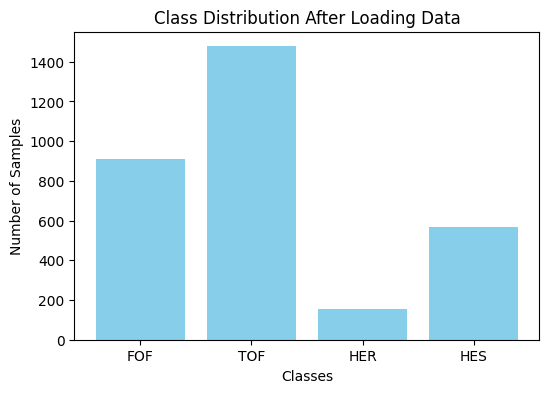


===== Fold 1/5 =====
After oversampling: Counter({np.int64(3): 1182, np.int64(2): 1182, np.int64(1): 1182, np.int64(0): 1182})


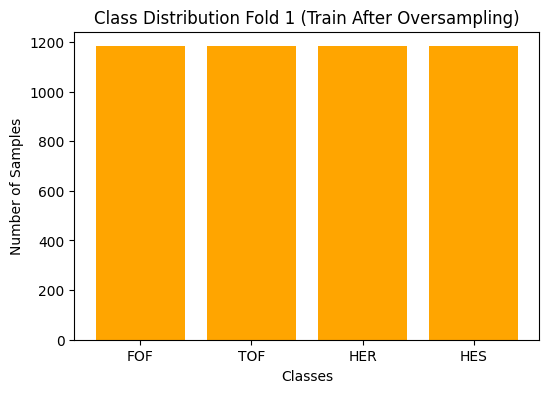

/tmp/ipython-input-6-1604576557.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipython-input-5-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1: Train Acc=0.337 | Val Acc=0.287
Epoch 2: Train Acc=0.455 | Val Acc=0.308
Epoch 3: Train Acc=0.515 | Val Acc=0.425
Epoch 4: Train Acc=0.546 | Val Acc=0.445
Epoch 5: Train Acc=0.574 | Val Acc=0.376
Epoch 6: Train Acc=0.585 | Val Acc=0.491
Epoch 7: Train Acc=0.622 | Val Acc=0.584
Epoch 8: Train Acc=0.628 | Val Acc=0.433
Epoch 9: Train Acc=0.652 | Val Acc=0.507
Epoch 10: Train Acc=0.656 | Val Acc=0.518
Epoch 11: Train Acc=0.674 | Val Acc=0.549
Epoch 12: Train Acc=0.682 | Val Acc=0.567
Epoch 13: Train Acc=0.691 | Val Acc=0.568
Epoch 14: Train Acc=0.711 | Val Acc=0.482
Epoch 15: Train Acc=0.720 | Val Acc=0.600
Epoch 16: Train Acc=0.727 | Val Acc=0.496
Epoch 17: Train Acc=0.727 | Val Acc=0.515
Epoch 18: Train Acc=0.742 | Val Acc=0.567
Epoch 19: Train Acc=0.738 | Val Acc=0.528
Epoch 20: Train Acc=0.757 | Val Acc=0.518
Epoch 21: Train Acc=0.758 | Val Acc=0.517
Epoch 22: Train Acc=0.750 | Val Acc=0.535
Epoch 23: Train Acc=0.769 | Val Acc=0.533
Epoch 24: Train Acc=0.774 | Val Acc=0.555
E

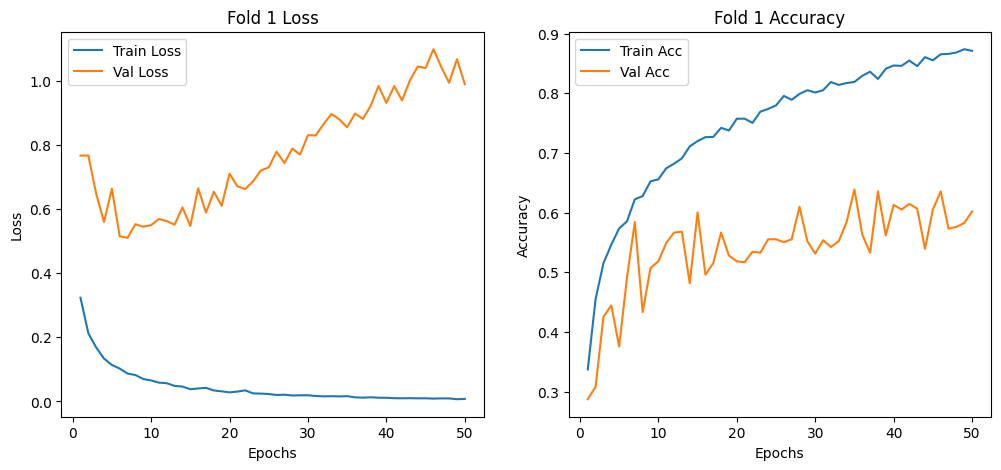

Fold 1 Final: Acc=0.602 Prec=0.657 Rec=0.602 F1=0.623


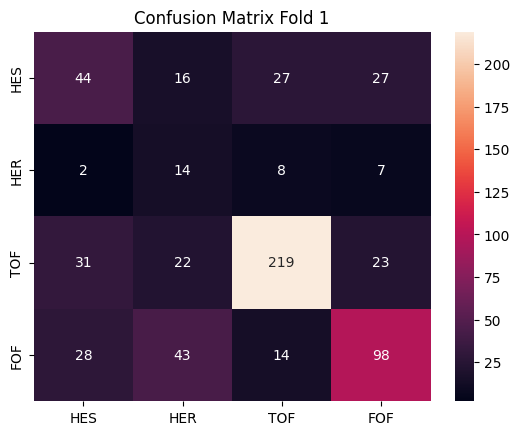


===== Fold 2/5 =====
After oversampling: Counter({np.int64(3): 1182, np.int64(2): 1182, np.int64(0): 1182, np.int64(1): 1182})


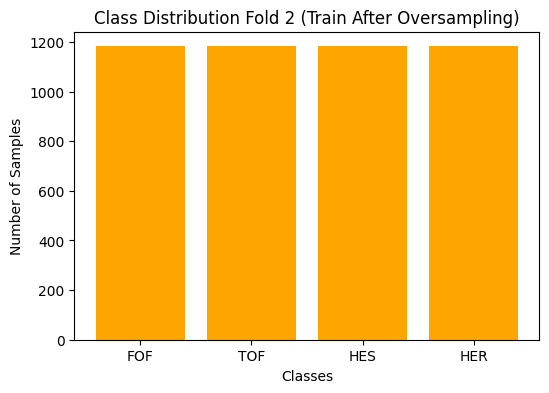

/tmp/ipython-input-6-1604576557.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipython-input-5-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1: Train Acc=0.323 | Val Acc=0.177
Epoch 2: Train Acc=0.448 | Val Acc=0.335
Epoch 3: Train Acc=0.503 | Val Acc=0.294
Epoch 4: Train Acc=0.557 | Val Acc=0.305
Epoch 5: Train Acc=0.573 | Val Acc=0.393
Epoch 6: Train Acc=0.602 | Val Acc=0.400
Epoch 7: Train Acc=0.622 | Val Acc=0.438
Epoch 8: Train Acc=0.630 | Val Acc=0.437
Epoch 9: Train Acc=0.645 | Val Acc=0.464
Epoch 10: Train Acc=0.680 | Val Acc=0.451
Epoch 11: Train Acc=0.680 | Val Acc=0.570
Epoch 12: Train Acc=0.699 | Val Acc=0.567
Epoch 13: Train Acc=0.702 | Val Acc=0.504
Epoch 14: Train Acc=0.720 | Val Acc=0.512
Epoch 15: Train Acc=0.719 | Val Acc=0.496
Epoch 16: Train Acc=0.724 | Val Acc=0.551
Epoch 17: Train Acc=0.750 | Val Acc=0.517
Epoch 18: Train Acc=0.748 | Val Acc=0.602
Epoch 19: Train Acc=0.751 | Val Acc=0.576
Epoch 20: Train Acc=0.750 | Val Acc=0.506
Epoch 21: Train Acc=0.769 | Val Acc=0.493
Epoch 22: Train Acc=0.772 | Val Acc=0.544
Epoch 23: Train Acc=0.778 | Val Acc=0.483
Epoch 24: Train Acc=0.782 | Val Acc=0.522
E

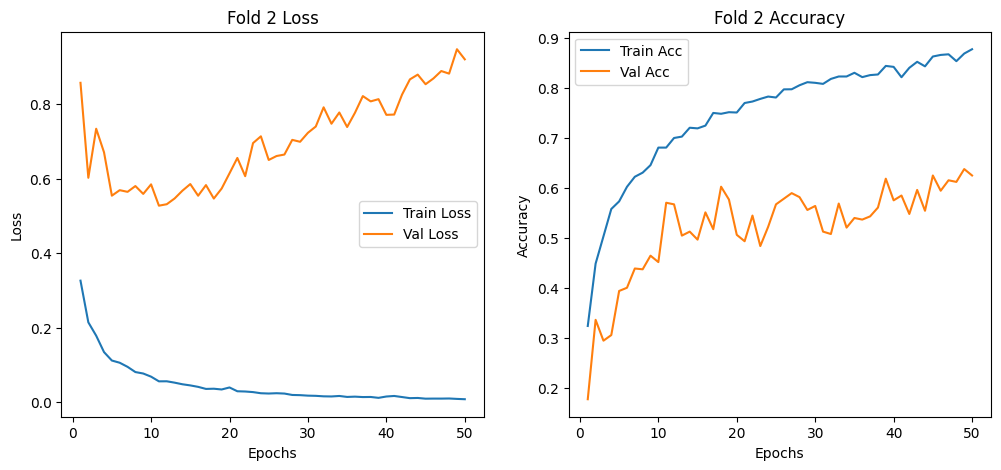

Fold 2 Final: Acc=0.624 Prec=0.647 Rec=0.624 F1=0.633


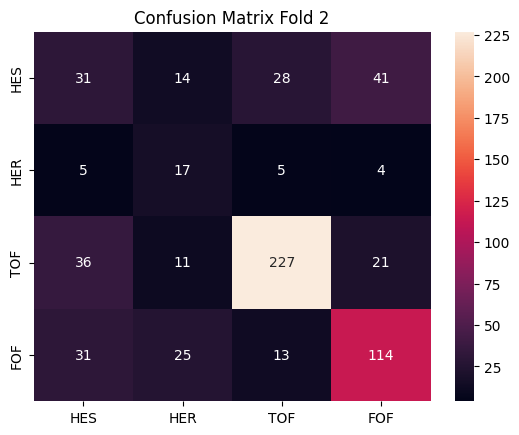


===== Fold 3/5 =====
After oversampling: Counter({np.int64(3): 1181, np.int64(2): 1181, np.int64(1): 1181, np.int64(0): 1181})


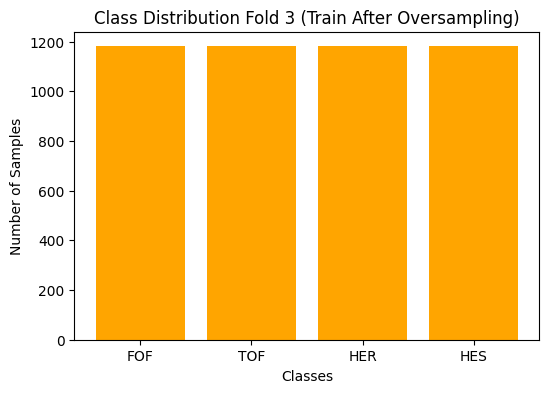

/tmp/ipython-input-6-1604576557.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipython-input-5-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1: Train Acc=0.337 | Val Acc=0.193
Epoch 2: Train Acc=0.457 | Val Acc=0.320
Epoch 3: Train Acc=0.514 | Val Acc=0.545
Epoch 4: Train Acc=0.567 | Val Acc=0.420
Epoch 5: Train Acc=0.579 | Val Acc=0.519
Epoch 6: Train Acc=0.620 | Val Acc=0.476
Epoch 7: Train Acc=0.636 | Val Acc=0.523
Epoch 8: Train Acc=0.659 | Val Acc=0.551
Epoch 9: Train Acc=0.676 | Val Acc=0.486
Epoch 10: Train Acc=0.691 | Val Acc=0.468
Epoch 11: Train Acc=0.697 | Val Acc=0.616
Epoch 12: Train Acc=0.707 | Val Acc=0.563
Epoch 13: Train Acc=0.721 | Val Acc=0.579
Epoch 14: Train Acc=0.731 | Val Acc=0.596
Epoch 15: Train Acc=0.743 | Val Acc=0.513
Epoch 16: Train Acc=0.749 | Val Acc=0.550
Epoch 17: Train Acc=0.753 | Val Acc=0.616
Epoch 18: Train Acc=0.765 | Val Acc=0.606
Epoch 19: Train Acc=0.760 | Val Acc=0.616
Epoch 20: Train Acc=0.765 | Val Acc=0.564
Epoch 21: Train Acc=0.780 | Val Acc=0.621
Epoch 22: Train Acc=0.784 | Val Acc=0.635
Epoch 23: Train Acc=0.797 | Val Acc=0.571
Epoch 24: Train Acc=0.792 | Val Acc=0.559
E

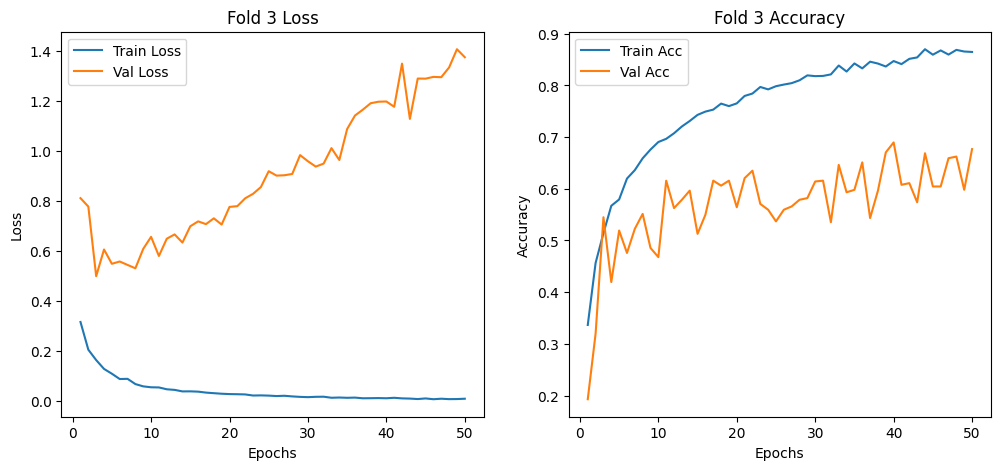

Fold 3 Final: Acc=0.677 Prec=0.678 Rec=0.677 F1=0.675


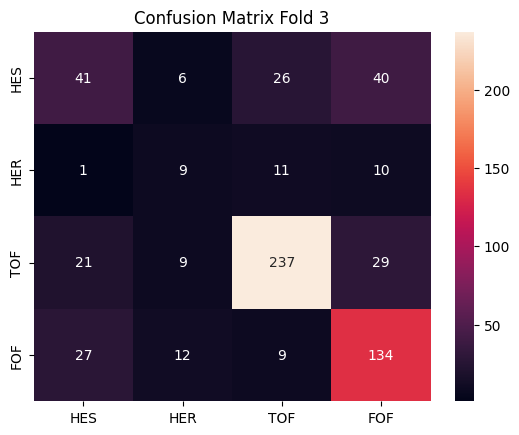


===== Fold 4/5 =====
After oversampling: Counter({np.int64(3): 1181, np.int64(2): 1181, np.int64(1): 1181, np.int64(0): 1181})


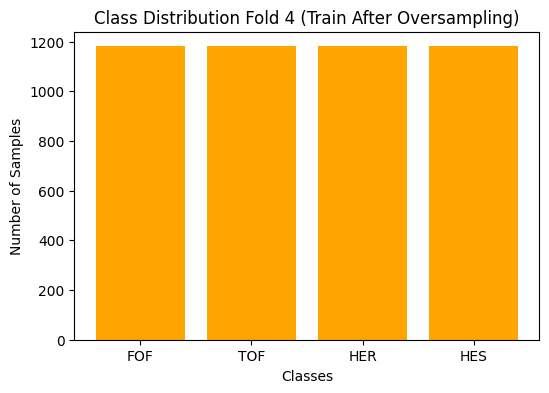

/tmp/ipython-input-6-1604576557.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipython-input-5-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1: Train Acc=0.326 | Val Acc=0.138
Epoch 2: Train Acc=0.442 | Val Acc=0.310
Epoch 3: Train Acc=0.510 | Val Acc=0.484
Epoch 4: Train Acc=0.555 | Val Acc=0.365
Epoch 5: Train Acc=0.597 | Val Acc=0.555
Epoch 6: Train Acc=0.622 | Val Acc=0.466
Epoch 7: Train Acc=0.646 | Val Acc=0.556
Epoch 8: Train Acc=0.657 | Val Acc=0.563
Epoch 9: Train Acc=0.669 | Val Acc=0.495
Epoch 10: Train Acc=0.682 | Val Acc=0.523
Epoch 11: Train Acc=0.699 | Val Acc=0.503
Epoch 12: Train Acc=0.710 | Val Acc=0.603
Epoch 13: Train Acc=0.727 | Val Acc=0.588
Epoch 14: Train Acc=0.725 | Val Acc=0.614
Epoch 15: Train Acc=0.739 | Val Acc=0.596
Epoch 16: Train Acc=0.749 | Val Acc=0.498
Epoch 17: Train Acc=0.752 | Val Acc=0.580
Epoch 18: Train Acc=0.762 | Val Acc=0.537
Epoch 19: Train Acc=0.764 | Val Acc=0.592
Epoch 20: Train Acc=0.771 | Val Acc=0.588
Epoch 21: Train Acc=0.773 | Val Acc=0.595
Epoch 22: Train Acc=0.773 | Val Acc=0.564
Epoch 23: Train Acc=0.786 | Val Acc=0.571
Epoch 24: Train Acc=0.792 | Val Acc=0.568
E

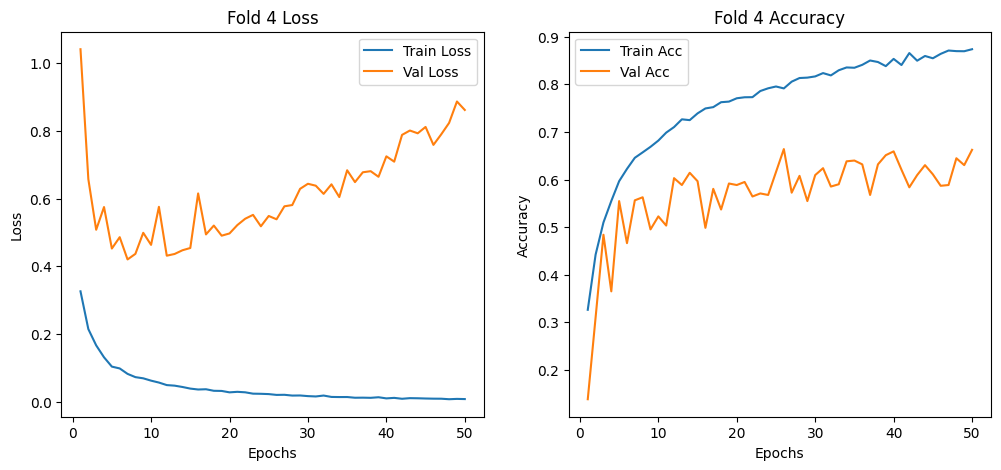

Fold 4 Final: Acc=0.662 Prec=0.692 Rec=0.662 F1=0.673


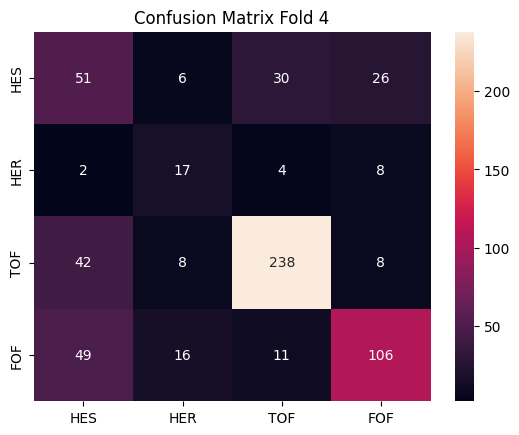


===== Fold 5/5 =====
After oversampling: Counter({np.int64(3): 1182, np.int64(2): 1182, np.int64(1): 1182, np.int64(0): 1182})


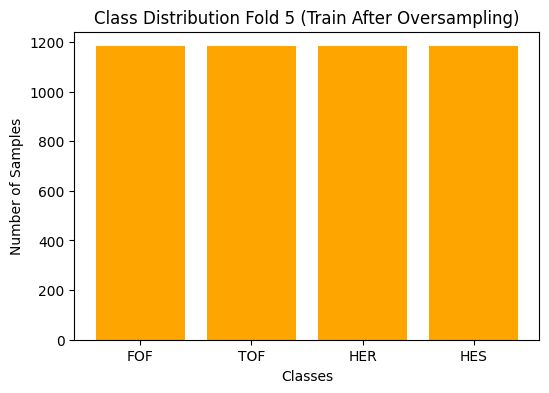

/tmp/ipython-input-6-1604576557.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipython-input-5-1112071204.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1: Train Acc=0.337 | Val Acc=0.190
Epoch 2: Train Acc=0.451 | Val Acc=0.379
Epoch 3: Train Acc=0.518 | Val Acc=0.400
Epoch 4: Train Acc=0.552 | Val Acc=0.399
Epoch 5: Train Acc=0.585 | Val Acc=0.477
Epoch 6: Train Acc=0.603 | Val Acc=0.471
Epoch 7: Train Acc=0.634 | Val Acc=0.418
Epoch 8: Train Acc=0.662 | Val Acc=0.489
Epoch 9: Train Acc=0.669 | Val Acc=0.455
Epoch 10: Train Acc=0.682 | Val Acc=0.439
Epoch 11: Train Acc=0.690 | Val Acc=0.477
Epoch 12: Train Acc=0.706 | Val Acc=0.484
Epoch 13: Train Acc=0.723 | Val Acc=0.476
Epoch 14: Train Acc=0.727 | Val Acc=0.508
Epoch 15: Train Acc=0.728 | Val Acc=0.524
Epoch 16: Train Acc=0.727 | Val Acc=0.490
Epoch 17: Train Acc=0.741 | Val Acc=0.531
Epoch 18: Train Acc=0.757 | Val Acc=0.510
Epoch 19: Train Acc=0.763 | Val Acc=0.518
Epoch 20: Train Acc=0.764 | Val Acc=0.529
Epoch 21: Train Acc=0.765 | Val Acc=0.514
Epoch 22: Train Acc=0.783 | Val Acc=0.556
Epoch 23: Train Acc=0.785 | Val Acc=0.494
Epoch 24: Train Acc=0.777 | Val Acc=0.503
E

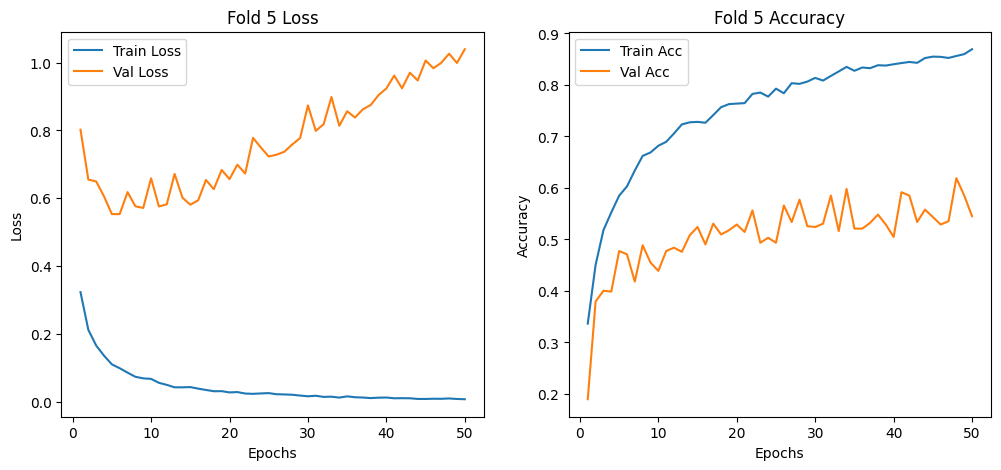

Fold 5 Final: Acc=0.545 Prec=0.613 Rec=0.545 F1=0.562


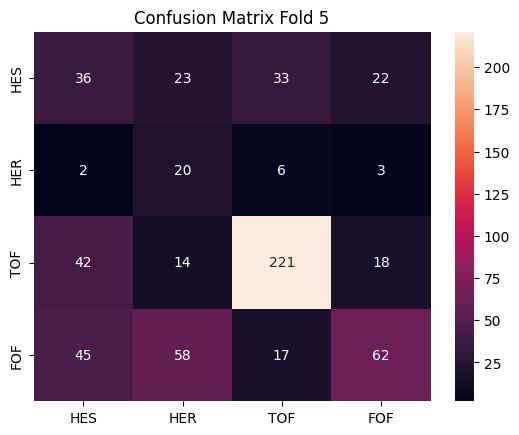


Average: acc     0.622114
prec    0.657348
rec     0.622114
f1      0.633104
dtype: float64


,fold,acc,prec,rec,f1
0,1,0.601926,0.656672,0.601926,0.623304
1,2,0.624398,0.647463,0.624398,0.632522
2,3,0.676849,0.677833,0.676849,0.674885
3,4,0.662379,0.692151,0.662379,0.673032
4,5,0.545016,0.612622,0.545016,0.561776


from matplotlib import pyplot as plt
_df_0['fold'].plot(kind='hist', bins=20, title='fold')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['acc'].plot(kind='hist', bins=20, title='acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['prec'].plot(kind='hist', bins=20, title='prec')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['rec'].plot(kind='hist', bins=20, title='rec')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='fold', y='acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='acc', y='prec', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='prec', y='rec', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='rec', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fold']
  ys = series['acc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('fold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fold')
_ = plt.ylabel('acc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fold']
  ys = series['prec']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('fold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fold')
_ = plt.ylabel('prec')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fold']
  ys = series['rec']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('fold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fold')
_ = plt.ylabel('rec')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fold']
  ys = series['f1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('fold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fold')
_ = plt.ylabel('f1')

from matplotlib import pyplot as plt
_df_12['fold'].plot(kind='line', figsize=(8, 4), title='fold')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['acc'].plot(kind='line', figsize=(8, 4), title='acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['prec'].plot(kind='line', figsize=(8, 4), title='prec')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['rec'].plot(kind='line', figsize=(8, 4), title='rec')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# ==================== USAGE =============================
root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['PD','EL']
frames,labels=load_all_group_data(root_dir,groups)
cross_validate(frames,labels,'/content/drive/MyDrive/IMU/kFold_Results_ActivityRecog_new',k=5,epochs=50,batch_size=32,lr=5e-5)